In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.patches as patches
import talib
from typing import Tuple, Optional, Dict, List
import warnings
warnings.filterwarnings('ignore')


In [2]:
def load_and_prepare_data(csv_file: str) -> pd.DataFrame:
    """
    Load MT5 CSV data and prepare it for analysis.

    Args:
        csv_file: Path to the CSV file

    Returns:
        Prepared DataFrame with DateTime index
    """
    try:
        df = pd.read_csv(csv_file)
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df.set_index('DateTime', inplace=True)

        # Ensure required columns exist
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        return df[required_cols].copy()

    except Exception as e:
        print(f"Error loading data: {e}")
        raise


In [3]:
def calculate_macd(df: pd.DataFrame, fast_period: int = 12, slow_period: int = 26,
                  signal_period: int = 9) -> pd.DataFrame:
    """
    Calculate MACD indicators and add them to the DataFrame.

    Args:
        df: Input DataFrame with OHLC data
        fast_period: Fast EMA period
        slow_period: Slow EMA period
        signal_period: Signal line EMA period

    Returns:
        DataFrame with MACD indicators added
    """
    df = df.copy()

    # Calculate MACD using talib
    macd_line, signal_line, macd_hist = talib.MACD(
        df['Close'],
        fastperiod=fast_period,
        slowperiod=slow_period,
        signalperiod=signal_period
    )

    df['MACD'] = macd_line
    df['MACD_Signal'] = signal_line
    df['MACD_Hist'] = macd_hist

    return df


In [4]:
def detect_macd_crossovers(df: pd.DataFrame) -> pd.Series:
    """
    Detect MACD crossovers with improved logic.

    Args:
        df: DataFrame with MACD and Signal columns

    Returns:
        Series with crossover signals: 1 (bullish), -1 (bearish), 0 (none)
    """
    crossovers = pd.Series(0, index=df.index, name='Crossover')

    # Ensure we have valid MACD data
    valid_mask = ~(df['MACD'].isna() | df['MACD_Signal'].isna())

    if valid_mask.sum() < 2:  # Need at least 2 valid points
        return crossovers

    # Bullish crossover: MACD crosses above Signal
    bullish_mask = (
        (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1)) &
        (df['MACD'] > df['MACD_Signal']) &
        valid_mask
    )
    crossovers[bullish_mask] = 1

    # Bearish crossover: MACD crosses below Signal
    bearish_mask = (
        (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1)) &
        (df['MACD'] < df['MACD_Signal']) &
        valid_mask
    )
    crossovers[bearish_mask] = -1

    return crossovers

In [5]:
def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """
    Calculate Average True Range (ATR).

    Args:
        df: DataFrame with OHLC data
        period: ATR calculation period

    Returns:
        ATR Series
    """
    return talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=period)


In [6]:
def calculate_stop_loss_take_profit(df: pd.DataFrame, sl_lookback: int = 1,
                                   tp_pips: float = 5.0, atr_period: int = 14,
                                   use_atr: bool = True, atr_sl_multiplier: float = 1.5,
                                   atr_tp_multiplier: float = 2.0) -> pd.DataFrame:
    """
    Calculate stop loss and take profit levels.

    Args:
        df: DataFrame with OHLC and crossover data
        sl_lookback: Number of candles to look back for SL calculation
        tp_pips: Take profit in pips (used when use_atr=False)
        atr_period: Period for ATR calculation
        use_atr: Whether to use ATR-based SL/TP
        atr_sl_multiplier: ATR multiplier for stop loss
        atr_tp_multiplier: ATR multiplier for take profit

    Returns:
        DataFrame with SL and TP columns added
    """
    df = df.copy()

    # Initialize SL and TP columns
    df['SL'] = np.nan
    df['TP'] = np.nan

    if use_atr:
        # Calculate ATR for dynamic SL/TP
        df['ATR'] = calculate_atr(df, atr_period)

    # Bullish crossovers
    bullish_mask = df['Crossover'] == 1
    if bullish_mask.any():
        if use_atr and 'ATR' in df.columns:
            # ATR-based SL/TP
            df.loc[bullish_mask, 'SL'] = df['Close'] - (atr_sl_multiplier * df['ATR'])
            df.loc[bullish_mask, 'TP'] = df['Close'] + (atr_tp_multiplier * df['ATR'])
        else:
            # Fixed approach
            df.loc[bullish_mask, 'SL'] = df['Low'].shift(sl_lookback)
            df.loc[bullish_mask, 'TP'] = df['Close'] + tp_pips

    # Bearish crossovers
    bearish_mask = df['Crossover'] == -1
    if bearish_mask.any():
        if use_atr and 'ATR' in df.columns:
            df.loc[bearish_mask, 'SL'] = df['Close'] + (atr_sl_multiplier * df['ATR'])
            df.loc[bearish_mask, 'TP'] = df['Close'] - (atr_tp_multiplier * df['ATR'])
        else:
            df.loc[bearish_mask, 'SL'] = df['High'].shift(sl_lookback)
            df.loc[bearish_mask, 'TP'] = df['Close'] - tp_pips

    return df

In [7]:
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add additional technical indicators for enhanced analysis.

    Args:
        df: Input DataFrame

    Returns:
        DataFrame with additional indicators
    """
    df = df.copy()

    # Moving averages
    df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
    df['EMA_50'] = talib.EMA(df['Close'], timeperiod=50)
    df['SMA_200'] = talib.SMA(df['Close'], timeperiod=200)

    # RSI
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # Bollinger Bands
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = talib.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2
    )

    # Stochastic
    df['Stoch_K'], df['Stoch_D'] = talib.STOCH(
        df['High'], df['Low'], df['Close'],
        fastk_period=14, slowk_period=3, slowd_period=3
    )

    return df

In [8]:
def apply_signal_filters(df: pd.DataFrame, use_trend_filter: bool = True,
                        use_rsi_filter: bool = True, rsi_oversold: float = 30,
                        rsi_overbought: float = 70, use_stoch_filter: bool = False) -> pd.DataFrame:
    """
    Apply filters to improve signal quality.

    Args:
        df: DataFrame with signals and indicators
        use_trend_filter: Filter signals based on trend direction
        use_rsi_filter: Filter signals based on RSI levels
        rsi_oversold: RSI oversold threshold
        rsi_overbought: RSI overbought threshold
        use_stoch_filter: Filter signals based on Stochastic levels

    Returns:
        DataFrame with filtered signals
    """
    df = df.copy()
    df['Filtered_Crossover'] = df['Crossover'].copy()

    if use_trend_filter and all(col in df.columns for col in ['EMA_20', 'EMA_50']):
        # Only take bullish signals when price is above EMA_50 (uptrend)
        uptrend_mask = df['Close'] > df['EMA_50']
        df.loc[(df['Crossover'] == 1) & (~uptrend_mask), 'Filtered_Crossover'] = 0

        # Only take bearish signals when price is below EMA_50 (downtrend)
        downtrend_mask = df['Close'] < df['EMA_50']
        df.loc[(df['Crossover'] == -1) & (~downtrend_mask), 'Filtered_Crossover'] = 0

    if use_rsi_filter and 'RSI' in df.columns:
        # Avoid bullish signals when RSI is overbought
        df.loc[(df['Crossover'] == 1) & (df['RSI'] > rsi_overbought), 'Filtered_Crossover'] = 0

        # Avoid bearish signals when RSI is oversold
        df.loc[(df['Crossover'] == -1) & (df['RSI'] < rsi_oversold), 'Filtered_Crossover'] = 0

    if use_stoch_filter and all(col in df.columns for col in ['Stoch_K', 'Stoch_D']):
        # Avoid bullish signals when Stochastic is overbought
        df.loc[(df['Crossover'] == 1) & (df['Stoch_K'] > 80), 'Filtered_Crossover'] = 0

        # Avoid bearish signals when Stochastic is oversold
        df.loc[(df['Crossover'] == -1) & (df['Stoch_K'] < 20), 'Filtered_Crossover'] = 0

    return df

In [9]:
def calculate_position_size(balance: float, risk_per_trade: float, entry_price: float,
                           sl_price: float) -> float:
    """
    Calculate position size based on risk management.

    Args:
        balance: Account balance
        risk_per_trade: Risk percentage per trade (0.02 = 2%)
        entry_price: Entry price
        sl_price: Stop loss price

    Returns:
        Position size
    """
    risk_amount = balance * risk_per_trade
    if abs(entry_price - sl_price) > 0:
        return risk_amount / abs(entry_price - sl_price)
    return 0

In [10]:
def backtest_strategy(df: pd.DataFrame, initial_balance: float = 10000,
                     risk_per_trade: float = 0.02, signal_column: str = 'Filtered_Crossover') -> Dict:
    """
    Backtest the trading strategy.

    Args:
        df: DataFrame with signals and SL/TP levels
        initial_balance: Starting account balance
        risk_per_trade: Risk percentage per trade
        signal_column: Column name containing trading signals

    Returns:
        Dictionary with backtest results
    """
    balance = initial_balance
    trades = []
    in_trade = False
    entry_price = 0
    trade_type = 0
    sl_price = 0
    tp_price = 0
    entry_date = None

    for idx, row in df.iterrows():
        if not in_trade and row[signal_column] != 0:
            # Enter trade
            in_trade = True
            entry_price = row['Close']
            trade_type = row[signal_column]
            sl_price = row['SL']
            tp_price = row['TP']
            entry_date = idx

        elif in_trade:
            # Check exit conditions
            hit_sl = False
            hit_tp = False

            if trade_type == 1:  # Long position
                hit_sl = row['Low'] <= sl_price
                hit_tp = row['High'] >= tp_price
            else:  # Short position
                hit_sl = row['High'] >= sl_price
                hit_tp = row['Low'] <= tp_price

            if hit_sl or hit_tp:
                exit_price = sl_price if hit_sl else tp_price

                # Calculate P&L
                if trade_type == 1:
                    pnl = exit_price - entry_price
                else:
                    pnl = entry_price - exit_price

                # Calculate position size
                position_size = calculate_position_size(balance, risk_per_trade, entry_price, sl_price)
                trade_pnl = pnl * position_size
                balance += trade_pnl

                trades.append({
                    'entry_date': entry_date,
                    'exit_date': idx,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'type': 'Long' if trade_type == 1 else 'Short',
                    'pnl': trade_pnl,
                    'hit_sl': hit_sl,
                    'position_size': position_size,
                    'balance': balance
                })

                in_trade = False

    return calculate_backtest_stats(trades, initial_balance, balance)

In [11]:
def calculate_backtest_stats(trades: List[Dict], initial_balance: float, final_balance: float) -> Dict:
    """
    Calculate backtest statistics.

    Args:
        trades: List of trade dictionaries
        initial_balance: Starting balance
        final_balance: Ending balance

    Returns:
        Dictionary with statistics
    """
    if not trades:
        return {
            'total_trades': 0, 'win_rate': 0, 'total_pnl': 0,
            'final_balance': final_balance, 'max_drawdown': 0,
            'avg_win': 0, 'avg_loss': 0, 'profit_factor': 0, 'trades': []
        }

    total_trades = len(trades)
    winning_trades = [t for t in trades if t['pnl'] > 0]
    losing_trades = [t for t in trades if t['pnl'] <= 0]

    win_rate = len(winning_trades) / total_trades * 100
    total_pnl = sum(t['pnl'] for t in trades)

    # Calculate drawdown
    max_drawdown = 0
    peak = initial_balance
    for trade in trades:
        if trade['balance'] > peak:
            peak = trade['balance']
        drawdown = (peak - trade['balance']) / peak * 100
        max_drawdown = max(max_drawdown, drawdown)

    # Additional stats
    avg_win = np.mean([t['pnl'] for t in winning_trades]) if winning_trades else 0
    avg_loss = np.mean([t['pnl'] for t in losing_trades]) if losing_trades else 0

    gross_profit = sum(t['pnl'] for t in winning_trades) if winning_trades else 0
    gross_loss = abs(sum(t['pnl'] for t in losing_trades)) if losing_trades else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else 0

    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'total_pnl': total_pnl,
        'final_balance': final_balance,
        'max_drawdown': max_drawdown,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'trades': trades
    }

In [12]:
def add_signal_markers(ax, df: pd.DataFrame, signal_column: str = 'Filtered_Crossover'):
    """Add buy/sell signal markers to the chart."""
    for i, row in df.iterrows():
        if row[signal_column] == 1:  # Bullish
            ax.scatter(i, row['Low'] * 0.999, marker='^', color='green', s=100, zorder=5)
        elif row[signal_column] == -1:  # Bearish
            ax.scatter(i, row['High'] * 1.001, marker='v', color='red', s=100, zorder=5)


In [13]:
def add_sl_tp_boxes(ax, df: pd.DataFrame, signal_column: str = 'Filtered_Crossover'):
    """Add stop loss and take profit boxes to the chart."""
    for i, row in df.iterrows():
        if row[signal_column] != 0 and not pd.isna(row['SL']) and not pd.isna(row['TP']):
            width = 0.8
            color = 'green' if row[signal_column] == 1 else 'red'

            rect = patches.Rectangle(
                (i - width/2, min(row['SL'], row['TP'])),
                width,
                abs(row['TP'] - row['SL']),
                color=color,
                alpha=0.2,
                linewidth=1,
                edgecolor=color
            )
            ax.add_patch(rect)


In [14]:
def plot_enhanced_chart(df: pd.DataFrame, start_idx: Optional[int] = None,
                       end_idx: Optional[int] = None, show_signals: bool = True,
                       show_boxes: bool = True, signal_column: str = 'Filtered_Crossover',
                       figsize: Tuple[int, int] = (16, 10)) -> Tuple:
    """
    Create an enhanced chart with multiple panels and indicators.

    Args:
        df: DataFrame with all indicators
        start_idx: Start index for plotting
        end_idx: End index for plotting
        show_signals: Whether to show crossover signals
        show_boxes: Whether to show SL/TP boxes
        signal_column: Column containing trading signals
        figsize: Figure size tuple

    Returns:
        Tuple of (figure, axes)
    """
    # Slice data if indices provided
    if start_idx is not None:
        df = df.iloc[start_idx:end_idx] if end_idx else df.iloc[start_idx:]

    df = df.copy().reset_index()

    # Prepare additional plots
    addplots = []

    # Moving averages on main panel
    if 'EMA_20' in df.columns:
        addplots.append(mpf.make_addplot(df['EMA_20'], color='orange', width=1))
    if 'EMA_50' in df.columns:
        addplots.append(mpf.make_addplot(df['EMA_50'], color='blue', width=1))
    if 'SMA_200' in df.columns:
        addplots.append(mpf.make_addplot(df['SMA_200'], color='red', width=1))

    # MACD on panel 1
    if 'MACD' in df.columns:
        addplots.append(mpf.make_addplot(df['MACD'], panel=1, color='green', width=1.2))
        addplots.append(mpf.make_addplot(df['MACD_Signal'], panel=1, color='red', width=1.2))
        addplots.append(mpf.make_addplot(df['MACD_Hist'], panel=1, type='bar', color='gray', alpha=0.5))

    # RSI on panel 2
    if 'RSI' in df.columns:
        addplots.append(mpf.make_addplot(df['RSI'], panel=2, color='purple', width=1))
        # RSI reference lines
        rsi_70 = pd.Series([70] * len(df), index=df.index)
        rsi_30 = pd.Series([30] * len(df), index=df.index)
        addplots.append(mpf.make_addplot(rsi_70, panel=2, color='red', linestyle='--', alpha=0.5))
        addplots.append(mpf.make_addplot(rsi_30, panel=2, color='green', linestyle='--', alpha=0.5))

    # Determine panel ratios
    num_panels = 1  # Main price panel
    if 'MACD' in df.columns:
        num_panels += 1
    if 'RSI' in df.columns:
        num_panels += 1

    panel_ratios = [3] + [1] * (num_panels - 1) if num_panels > 1 else None

    # Create the plot
    fig, axes = mpf.plot(
        df.set_index('DateTime'),
        type='candle',
        style='charles',
        volume=False,
        figsize=figsize,
        returnfig=True,
        addplot=addplots if addplots else None,
        title='Enhanced MACD Trading Strategy',
        panel_ratios=panel_ratios,
        tight_layout=True
    )

    main_ax = axes[0] if isinstance(axes, (list, tuple)) else axes

    # Add signal markers
    if show_signals and signal_column in df.columns:
        add_signal_markers(main_ax, df, signal_column)

    # Add SL/TP boxes
    if show_boxes and all(col in df.columns for col in ['SL', 'TP']) and signal_column in df.columns:
        add_sl_tp_boxes(main_ax, df, signal_column)

    return fig, axes

In [15]:
def print_backtest_results(results: Dict):
    """
    Print formatted backtest results.

    Args:
        results: Dictionary containing backtest results
    """
    print("\n" + "="*50)
    print("           BACKTEST RESULTS")
    print("="*50)
    print(f"Total Trades:      {results['total_trades']}")
    print(f"Win Rate:          {results['win_rate']:.2f}%")
    print(f"Total P&L:         ${results['total_pnl']:.2f}")
    print(f"Final Balance:     ${results['final_balance']:.2f}")
    print(f"Max Drawdown:      {results['max_drawdown']:.2f}%")
    print(f"Average Win:       ${results['avg_win']:.2f}")
    print(f"Average Loss:      ${results['avg_loss']:.2f}")
    print(f"Profit Factor:     {results['profit_factor']:.2f}")
    print(f"Gross Profit:      ${results['gross_profit']:.2f}")
    print(f"Gross Loss:        ${results['gross_loss']:.2f}")
    print("="*50)

In [16]:
def run_complete_macd_analysis(csv_file: str, macd_fast: int = 12, macd_slow: int = 26,
                              macd_signal: int = 9, use_atr_sl_tp: bool = True,
                              use_filters: bool = True, initial_balance: float = 10000,
                              risk_per_trade: float = 0.02, plot_start_idx: Optional[int] = None) -> Tuple[pd.DataFrame, Dict]:
    """
    Run the complete MACD trading strategy analysis.

    Args:
        csv_file: Path to the CSV file
        macd_fast: MACD fast period
        macd_slow: MACD slow period
        macd_signal: MACD signal period
        use_atr_sl_tp: Whether to use ATR-based SL/TP
        use_filters: Whether to apply signal filters
        initial_balance: Starting balance for backtest
        risk_per_trade: Risk percentage per trade
        plot_start_idx: Start index for plotting (None = plot all data)

    Returns:
        Tuple of (processed DataFrame, backtest results)
    """
    print("Loading and preparing data...")
    df = load_and_prepare_data(csv_file)

    print("Calculating MACD indicators...")
    df = calculate_macd(df, macd_fast, macd_slow, macd_signal)

    print("Detecting crossovers...")
    df['Crossover'] = detect_macd_crossovers(df)

    print("Adding technical indicators...")
    df = add_technical_indicators(df)

    print("Calculating stop loss and take profit levels...")
    df = calculate_stop_loss_take_profit(df, use_atr=use_atr_sl_tp)

    if use_filters:
        print("Applying signal filters...")
        df = apply_signal_filters(df)
        signal_col = 'Filtered_Crossover'
    else:
        df['Filtered_Crossover'] = df['Crossover']
        signal_col = 'Crossover'

    print("Running backtest...")
    backtest_results = backtest_strategy(df, initial_balance, risk_per_trade, signal_col)

    # Print results
    print_backtest_results(backtest_results)

    print("\nGenerating chart...")
    fig, axes = plot_enhanced_chart(df, start_idx=plot_start_idx, signal_column=signal_col)

    return df, backtest_results

Loading and preparing data...
Calculating MACD indicators...
Detecting crossovers...
Adding technical indicators...
Calculating stop loss and take profit levels...
Applying signal filters...
Running backtest...

           BACKTEST RESULTS
Total Trades:      606
Win Rate:          44.22%
Total P&L:         $2517.26
Final Balance:     $12517.26
Max Drawdown:      44.91%
Average Win:       $265.71
Average Loss:      $-203.23
Profit Factor:     1.04
Gross Profit:      $71209.17
Gross Loss:        $68691.91

Generating chart...

Results saved to: enhanced_macd_analysis_functional.csv


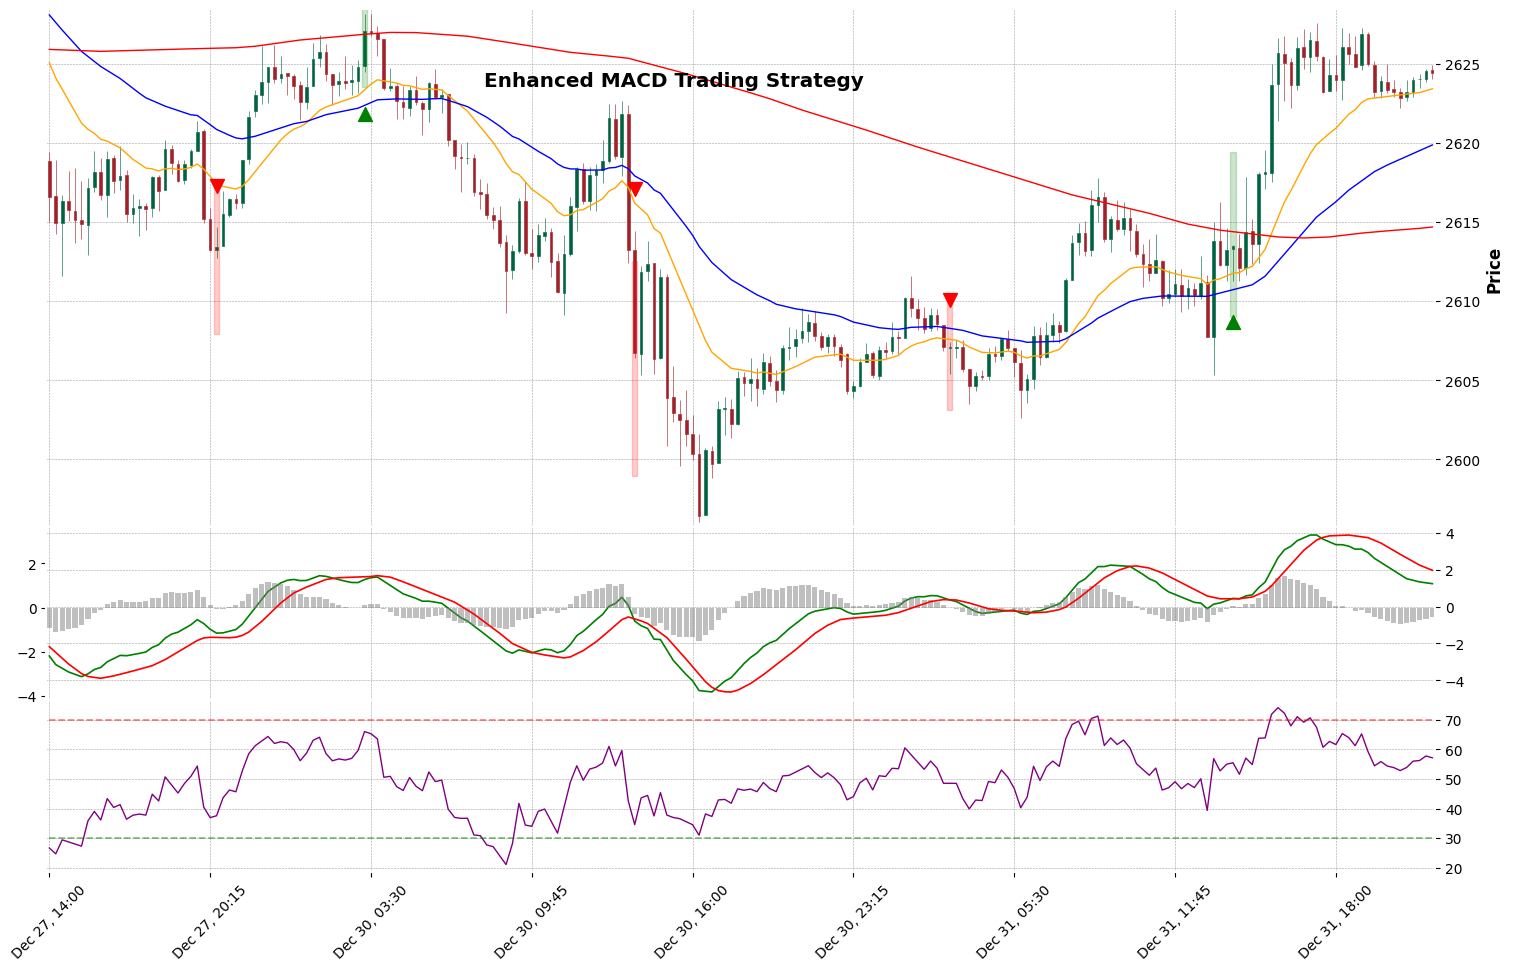


First few Filtered_Crossover signals:
                         Open      High       Low     Close      MACD  \
DateTime                                                                
2024-01-02 18:45:00  2061.632  2062.461  2060.514  2061.164 -1.706239   
2024-01-03 06:00:00  2064.024  2065.373  2063.566  2065.151  0.589228   
2024-01-04 06:15:00  2045.102  2048.590  2044.817  2047.024  0.907831   
2024-01-04 09:30:00  2047.086  2050.958  2047.086  2049.838  1.271156   
2024-01-04 10:15:00  2048.259  2050.826  2048.096  2049.280  1.240812   

                     MACD_Signal  Filtered_Crossover           SL           TP  
DateTime                                                                        
2024-01-02 18:45:00    -1.644634                  -1  2065.734848  2055.069536  
2024-01-03 06:00:00     0.560010                   1  2062.968234  2068.061355  
2024-01-04 06:15:00     0.866185                   1  2044.292259  2050.666321  
2024-01-04 09:30:00     1.241760            

In [17]:
if __name__ == "__main__":
    # Configuration parameters
    CONFIG = {
        'csv_file': "xauusdm15.filtered.csv",
        'macd_fast': 12,
        'macd_slow': 26,
        'macd_signal': 9,
        'use_atr_sl_tp': True,
        'use_filters': True,
        'initial_balance': 10000,
        'risk_per_trade': 0.02,
        'plot_start_idx': 23300  # Set to None to plot all data
    }

    try:
        # Run complete analysis
        df, results = run_complete_macd_analysis(**CONFIG)

        # Save results to CSV
        output_filename = "enhanced_macd_analysis_functional.csv"
        df.to_csv(output_filename)
        print(f"\nResults saved to: {output_filename}")

        # Show the plot
        mpf.show()

        # Optional: Print first few signal rows
        signal_col = 'Filtered_Crossover' if CONFIG['use_filters'] else 'Crossover'
        signal_rows = df[df[signal_col] != 0].head()
        if not signal_rows.empty:
            print(f"\nFirst few {signal_col} signals:")
            print(signal_rows[['Open', 'High', 'Low', 'Close', 'MACD', 'MACD_Signal', signal_col, 'SL', 'TP']])

    except FileNotFoundError:
        print(f"Error: CSV file '{CONFIG['csv_file']}' not found.")
        print("Please ensure the file exists in the current directory.")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

In [18]:
# Additional utility functions for advanced analysis
def analyze_signal_performance(df: pd.DataFrame, signal_column: str = 'Filtered_Crossover') -> Dict:
    """
    Analyze performance by signal type.

    Args:
        df: DataFrame with signals
        signal_column: Column containing signals

    Returns:
        Dictionary with signal performance stats
    """
    bullish_signals = df[df[signal_column] == 1]
    bearish_signals = df[df[signal_column] == -1]

    return {
        'total_bullish': len(bullish_signals),
        'total_bearish': len(bearish_signals),
        'avg_bullish_close': bullish_signals['Close'].mean() if len(bullish_signals) > 0 else 0,
        'avg_bearish_close': bearish_signals['Close'].mean() if len(bearish_signals) > 0 else 0
    }

In [19]:
def optimize_parameters(df: pd.DataFrame, fast_range: range = range(8, 16),
                       slow_range: range = range(21, 35),
                       signal_range: range = range(5, 15)) -> Dict:
    """
    Simple parameter optimization (grid search).

    Args:
        df: DataFrame with OHLC data
        fast_range: Range of fast periods to test
        slow_range: Range of slow periods to test
        signal_range: Range of signal periods to test

    Returns:
        Dictionary with best parameters and performance
    """
    best_params = {'fast': 12, 'slow': 26, 'signal': 9}
    best_performance = -float('inf')

    print("Running parameter optimization...")

    for fast in fast_range:
        for slow in slow_range:
            if slow <= fast:
                continue
            for signal in signal_range:
                # Calculate MACD with current parameters
                test_df = calculate_macd(df.copy(), fast, slow, signal)
                test_df['Crossover'] = detect_macd_crossovers(test_df)
                test_df = calculate_stop_loss_take_profit(test_df)
                test_df = apply_signal_filters(test_df)

                # Run backtest
                results = backtest_strategy(test_df, signal_column='Filtered_Crossover')

                # Use profit factor as optimization metric
                performance = results['profit_factor']

                if performance > best_performance:
                    best_performance = performance
                    best_params = {'fast': fast, 'slow': slow, 'signal': signal}

    return {
        'best_params': best_params,
        'best_performance': best_performance
    }